# Classifying Merger Images Using CNN 

- Data from Illustris 
- Three merger classes defined by merger trees and merger fractions at $z = 0.2$

In [1]:
import matplotlib.pyplot as plt 
from glob import glob
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization

import tensorflow.keras.utils as np_utils
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
#import tensorflow_addons as tfa
from keras.models import Model

from matplotlib.colors import ListedColormap
#from keras.utils.training_utils import multi_gpu_model


from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import os
import pandas as pd


import pickle
from joblib import dump, load

# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 13})
plt.rcParams['mathtext.fontset'] = 'stix'

#### GPU 메모리 자동 증가 설정

In [2]:
# GPU 메모리 자동 증가 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

## Read data

In [3]:
!pwd

/tf/work/merger/notebook


In [4]:
!ls /tf/work/merger/data/

1000data.pkl  500data.pkl  models


#### Trying 500 x 500 images 

In [5]:
import pickle

with open('/tf/work/merger/data/500data.pkl', "rb") as f:
    data = pickle.load(f)

In [6]:
len(data)

6

In [7]:
for eachdata in data:
    print('shape: '+str(eachdata.shape))
    print('dtype: '+str(eachdata.dtype))

shape: (252, 500, 500)
dtype: float64
shape: (252,)
dtype: float64
shape: (64, 500, 500)
dtype: float64
shape: (64,)
dtype: float64
shape: (80, 500, 500)
dtype: float64
shape: (80,)
dtype: float64


- Labels `y` should be integer, not float. Why?!? Please google it and enlighten yourself.

#### Maybe, give names as `X_train, y_train,X_val, y_val,X_test, y_test`

In [8]:
X_train = data[0].copy()
y_train = data[1].copy().astype(int)
X_val = data[2].copy()
y_val = data[3].copy().astype(int)
X_test = data[4].copy()
y_test = data[5].copy().astype(int)

- References vs. Hard Copies

In [9]:
grids = 500

- Image Size

In [10]:
np.unique(y_train)

array([0, 1, 2])

#### Randomize `X_train` and `y_train`

In [11]:
numtrain = X_train.shape[0]
print(numtrain)

252


In [12]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [13]:
X_nan = np.array([np.count_nonzero(np.isnan(X_train[i,:,:])) for i in range(numtrain)])

In [14]:
X_nan

array([36496, 51282, 27840, 23458,  5821, 47988, 48160, 85104, 71980,
        3713, 41496, 50778, 33719, 87877, 37446, 46422, 32405, 41325,
       25538, 11911, 46442, 22796, 74830, 29440, 74330, 65080,  3365,
       82049, 75388, 67077, 71555, 52892, 59927, 34489, 55452, 72932,
       71990, 29409, 84000, 71851, 82058, 38634,  1761, 66909, 43559,
       50042, 41813, 76049, 59364, 52093, 78858, 46670, 73974,  4759,
       17563, 68137, 28051, 73324, 66941, 70296, 23113, 82559, 36015,
       73850, 42124, 32173, 48828, 46930, 79018, 37612, 41022, 54229,
       27757, 46189, 70670, 15004, 82195, 58309, 68846, 61995, 60290,
       20805, 80760, 38390, 47508, 90367, 24425, 29323, 75722, 62174,
       30380, 32658, 19744, 50393, 33866, 35045, 53057, 59760, 34659,
       21647, 64973, 61797, 12371, 69529, 33810, 55297, 38588, 49311,
        6057, 49340, 70046, 50618, 53278, 59049, 17089, 76041, 74853,
       43670, 14497, 52812, 54208, 44283, 27496, 30597, 50919, 57947,
       80797, 36172,

In [15]:
import random

In [16]:
randidx = list(range(numtrain))

In [17]:
random.shuffle(randidx)

In [18]:
y_train[randidx]

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 2, 0, 2, 1, 0, 1, 0, 0, 1, 0, 2, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 2, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 2, 0, 1, 0, 0, 0, 2, 1, 0, 1, 2, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 0, 0, 1, 1, 0, 1, 1, 0, 2,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [19]:
randidx[:3]

[121, 28, 129]

In [20]:
y_train[randidx[:3]], X_nan[randidx[:3]]

(array([0, 0, 0]), array([44283, 75388, 71961]))

In [21]:
X_train = X_train[randidx]
y_train = y_train[randidx]

## Let's explore the images 

#### Show Images 

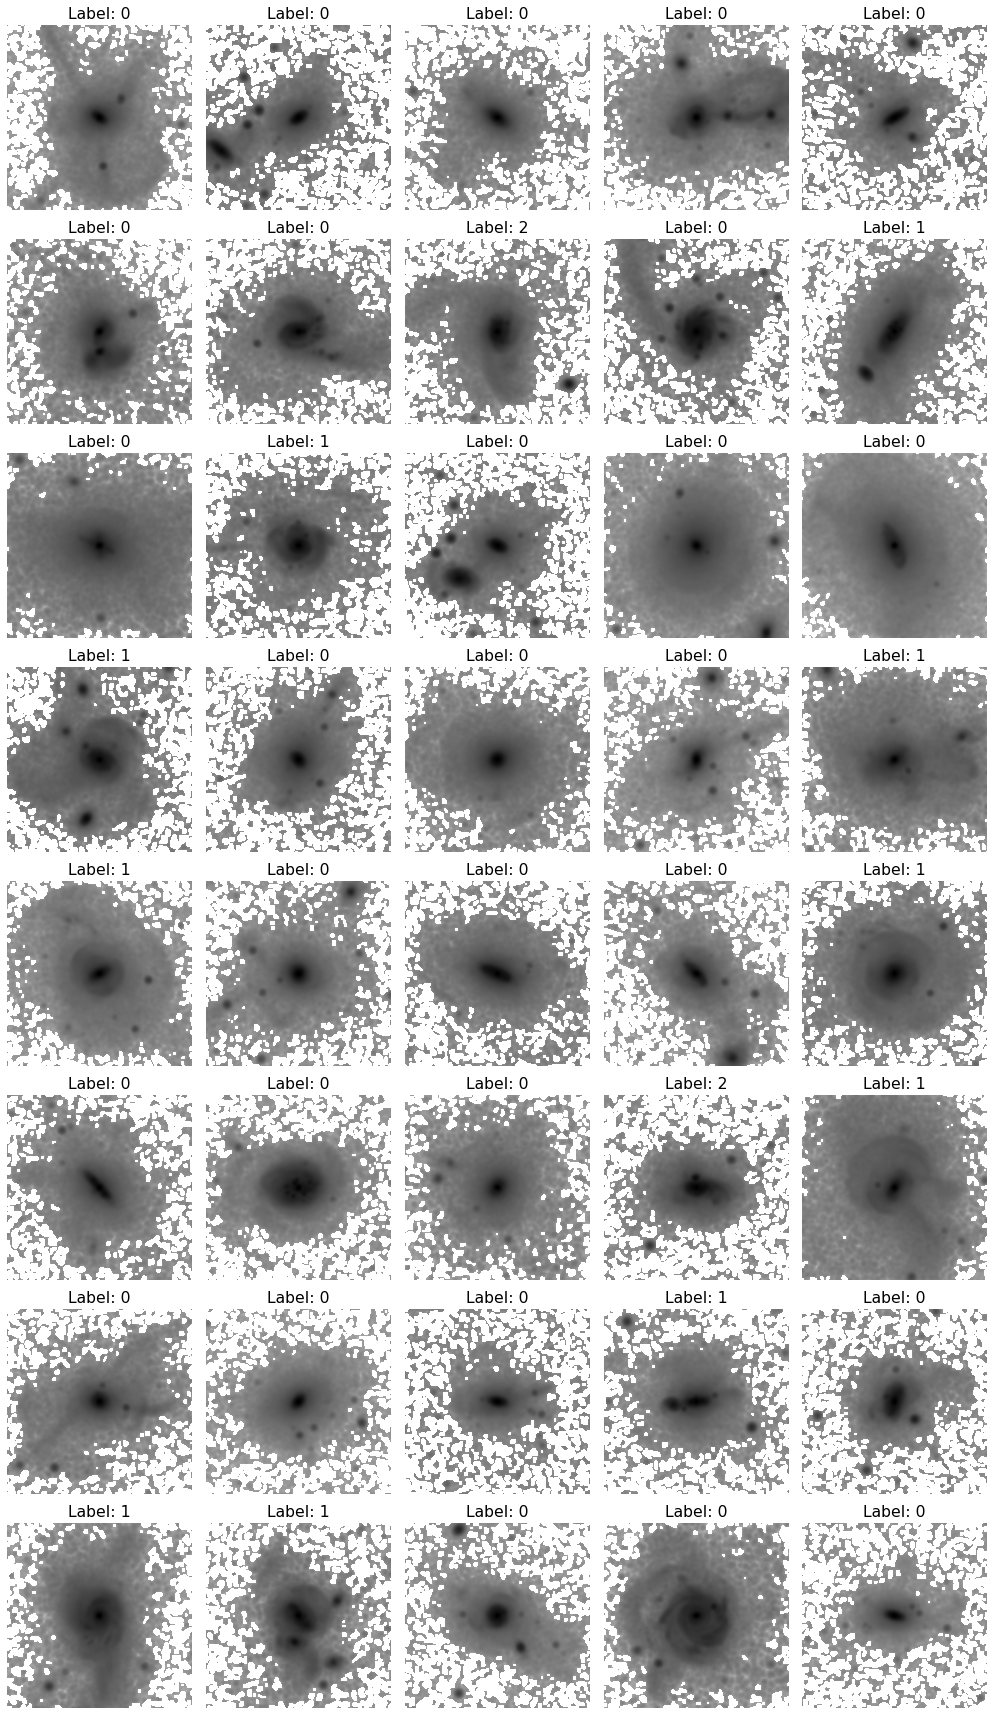

In [22]:
fig=plt.figure(figsize=(14, 24))
for i in range(40):
    ax=plt.subplot(8, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title('Label: '+str(y_train[i]))
    plt.axis('off')
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

#### Check the basic pixel statistics 

In [23]:
np.nanmax(X_test), np.nanmin(X_test), np.nanmedian(X_test)

(50.224803408358454, 16.46315515204806, 31.952053298057773)

In [24]:
X_test[0].shape

(500, 500)

In [25]:
np.count_nonzero(np.isnan(X_test[0]))

71102

In [26]:
np.nanmax(X_test[0]), np.nanmin(X_test[0])

(45.670683799169204, 18.53099251901252)

## Masking Images by `SB < 26 mag`

#### Trying some masks on `numpy.array`

In [27]:
medvalue = np.nanmedian(X_train)
print(medvalue)

32.02873972939746


In [28]:
minvalue = np.nanmin(X_train)
print(minvalue)

16.373567689693267


In [29]:
maxvalue = np.nanmax(X_train)
print(maxvalue)

51.882674692480236


In [30]:
threshold = 26

In [31]:
thismask = X_test < threshold

In [32]:
np.nanmax(X_test[thismask]), np.nanmin(X_test[thismask])

(25.999999074646542, 16.46315515204806)

In [33]:
notmask = X_test >= threshold

In [34]:
np.nanmax(X_test[notmask]), np.nanmin(X_test[notmask])

(50.224803408358454, 26.000004659211903)

#### Masking out `SB < 26 mag` as `SB = 26`

In [35]:
#X_test[X_test<26.0]=0.0
#X_val[X_val<26.0]=0.0
#X_train[X_train<26.0]=0.0

X_test[X_test<26.0]=medvalue
X_val[X_val<26.0]=medvalue
X_train[X_train<26.0]=medvalue

In [36]:
np.nanmax(X_test), np.nanmin(X_test), np.nanmax(X_train), np.nanmin(X_train), np.nanmax(X_val), np.nanmin(X_val)

(50.224803408358454,
 26.000004659211903,
 51.882674692480236,
 26.000001594583132,
 50.98979028051181,
 26.000000652554085)

#### Masking out `nan` and `inf` too

In [37]:
np.count_nonzero(np.isnan(X_test)), np.count_nonzero(np.isinf(X_test))

(3432519, 0)

In [38]:
#X_test[np.isnan(X_test)]=0.0
#X_val[np.isnan(X_val)]=0.0
#X_train[np.isnan(X_train)]=0.0

X_test[np.isnan(X_test)]=maxvalue
X_val[np.isnan(X_val)]=maxvalue
X_train[np.isnan(X_train)]=maxvalue

In [39]:
np.nanmax(X_test), np.nanmin(X_test), np.nanmax(X_train), np.nanmin(X_train), np.nanmax(X_val), np.nanmin(X_val)

(51.882674692480236,
 26.000004659211903,
 51.882674692480236,
 26.000001594583132,
 51.882674692480236,
 26.000000652554085)

In [40]:
print(np.count_nonzero(np.isnan(X_train)), np.count_nonzero(np.isinf(X_train)))
print(np.count_nonzero(np.isnan(X_test)), np.count_nonzero(np.isinf(X_test)))
print(np.count_nonzero(np.isnan(X_val)), np.count_nonzero(np.isinf(X_val)))

0 0
0 0
0 0


In [41]:
maxval = np.max([np.max(X_train),np.max(X_val),np.max(X_test)])
minval = np.min([np.min(X_train),np.min(X_val),np.min(X_test)])

In [42]:
maxval, minval

(51.882674692480236, 26.000000652554085)

## Reshaping & Normalization

In [43]:
%%time
#num_pixels = X_train.shape[1] * X_train.shape[2]
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0],grids,grids,1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0],grids,grids,1)).astype('float32')
X_val = X_val.reshape((X_val.shape[0],grids,grids,1)).astype('float32')
print(X_train.shape)

#Normalization                          

X_train = np.abs(1.0 - (X_train - minval) / (maxval - minval))
X_test = np.abs(1.0 - (X_test - minval) / (maxval - minval))
X_val = np.abs(1.0 - (X_val - minval) / (maxval - minval))

#X_train = X_train / maxval
#X_test = X_test / maxval
#X_val = X_val / maxval


(252, 500, 500)
(252, 500, 500, 1)
CPU times: user 260 ms, sys: 136 ms, total: 396 ms
Wall time: 394 ms


In [44]:
np.nanmax(X_test), np.nanmin(X_test), np.nanmax(X_train), np.nanmin(X_train), np.nanmax(X_val), np.nanmin(X_val)

(0.9999999, 1.1920929e-07, 0.99999994, 1.1920929e-07, 1.0, 1.1920929e-07)

#### Show images after normalization

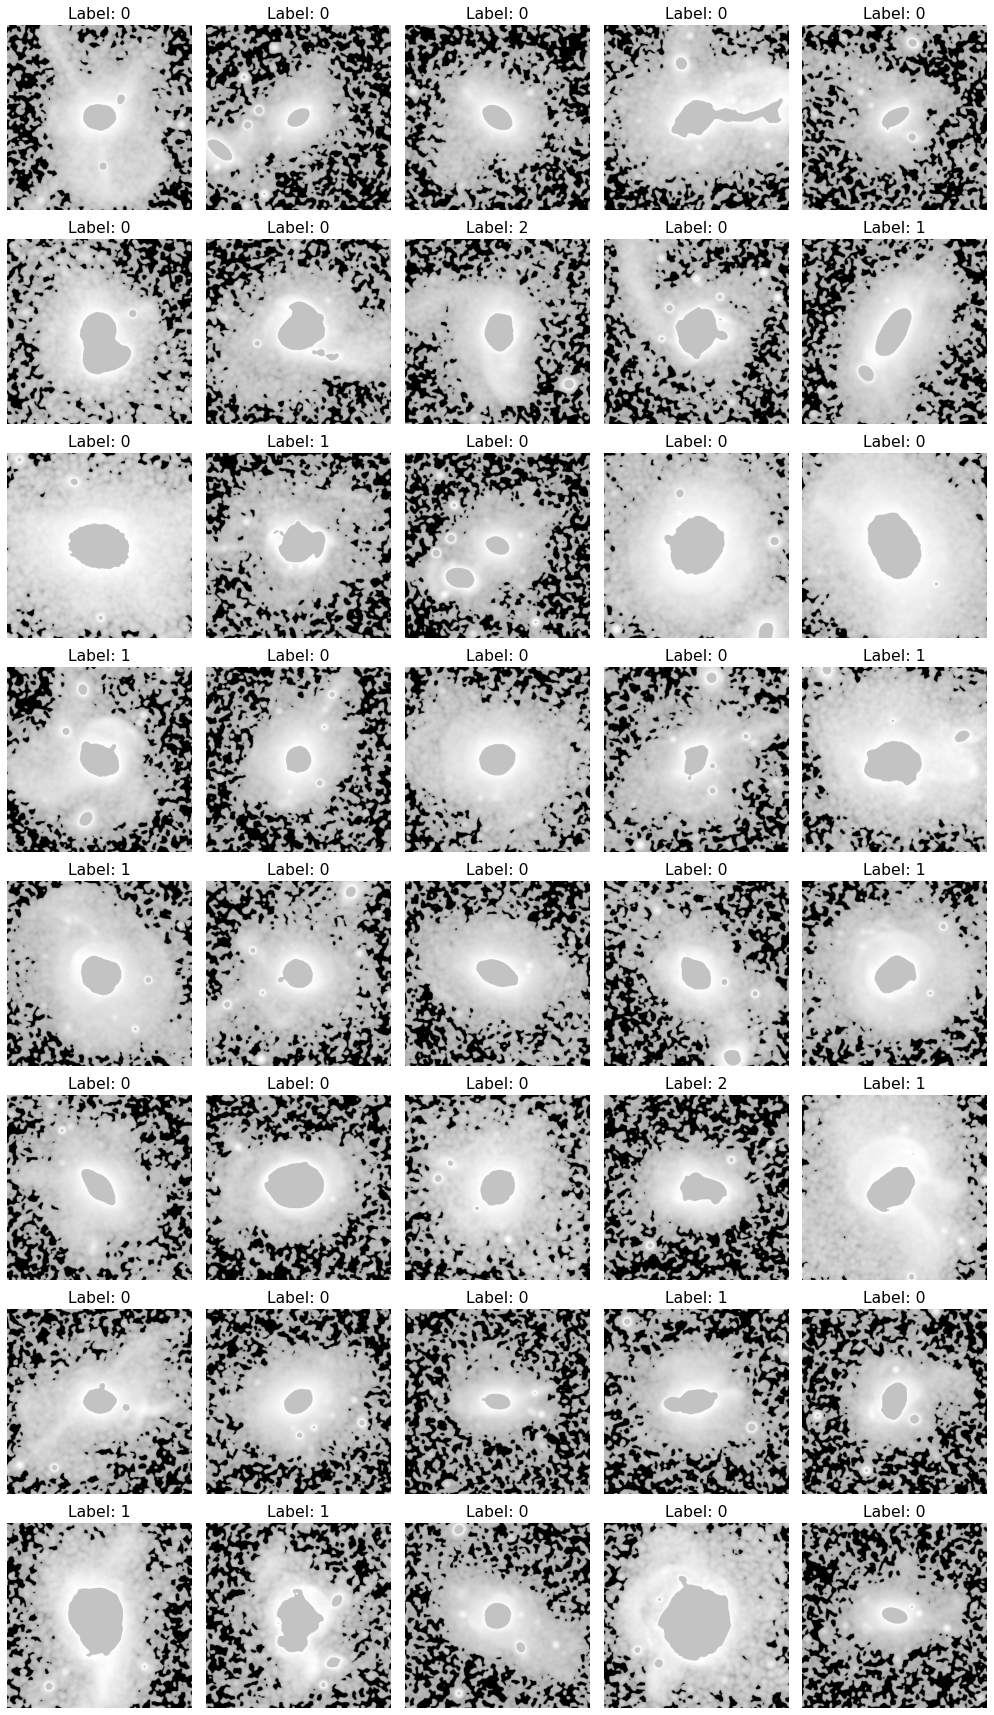

In [45]:
fig=plt.figure(figsize=(14, 24))
for i in range(40):
    ax=plt.subplot(8, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title('Label: '+str(y_train[i]))
    plt.axis('off')
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

# 4. one-hot encoding outputs

In [46]:
%%time
y_train_hot = np_utils.to_categorical(y_train)
y_test_hot = np_utils.to_categorical(y_test)
y_val_hot = np_utils.to_categorical(y_val)
num_classes = y_test_hot.shape[1]

CPU times: user 272 µs, sys: 107 µs, total: 379 µs
Wall time: 287 µs


In [47]:
y_test[:3]

array([0, 0, 0])

In [48]:
y_test_hot[:3]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [49]:
print(num_classes)

3


# 5. Model building

In [50]:
strategy = tf.distribute.MirroredStrategy()
Droprate=0.2
def baseline_model():
# create model
    model = Sequential()
    model.add(Conv2D(32, (9, 9), input_shape=(grids,grids, 1),strides=(1, 1), activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(Droprate))
    
    model.add(Conv2D(64, (7, 7), activation='relu',strides=(1, 1),padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(Droprate))
    
    model.add(Conv2D(64, (5, 5), activation='relu',strides=(1, 1),padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(Droprate))
    
    model.add(Conv2D(128, (3, 3), activation='relu',strides=(1, 1),padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(Droprate))
    
    model.add(Conv2D(256, (3, 3), activation='relu',strides=(1, 1),padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(Droprate))

    
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])    
    #model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])    
    
    return model

# build the model
with strategy.scope():
    model=baseline_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 500, 32)      2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 500, 500, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 250, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 250, 250, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 64)      100416    
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 250, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 64)      0

# Fitting Model

In [52]:
!pwd

/tf/work/merger/notebook


In [53]:
#start_time = tf.timestamp()

# Fit the model

history=model.fit(X_train, y_train_hot, validation_data=(X_val, y_val_hot), epochs=300, batch_size=59, verbose=2)
#history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=50, verbose=2)


# Final evaluation of the model

#model.save(model_path)

scores = model.evaluate(X_test, y_test_hot, verbose=0)
#scores = model.evaluate(X_test, y_test, verbose=0)


print("Baseline Error: %.2f%%" % (100-scores[1]*100))



# 실행 시간 계산
#end_time = tf.timestamp()
#execution_time = end_time - start_time
#print("Execution time: ", execution_time.numpy(), " seconds")

# history 객체를 저장
#dump(history.history, '/tf/work/merger/data/histories/tmplog'+'.joblib')

Epoch 1/300
5/5 - 11s - loss: 39.8837 - accuracy: 0.4643 - val_loss: 4.0420 - val_accuracy: 0.6719
Epoch 2/300
5/5 - 1s - loss: 1.1378 - accuracy: 0.6508 - val_loss: 17.2943 - val_accuracy: 0.6719
Epoch 3/300
5/5 - 1s - loss: 0.8464 - accuracy: 0.6944 - val_loss: 29.3502 - val_accuracy: 0.6719
Epoch 4/300
5/5 - 1s - loss: 0.7215 - accuracy: 0.7024 - val_loss: 36.1367 - val_accuracy: 0.6719
Epoch 5/300
5/5 - 1s - loss: 0.6613 - accuracy: 0.7302 - val_loss: 40.1844 - val_accuracy: 0.6719
Epoch 6/300
5/5 - 1s - loss: 0.6199 - accuracy: 0.7222 - val_loss: 27.4175 - val_accuracy: 0.6719
Epoch 7/300
5/5 - 1s - loss: 0.6590 - accuracy: 0.7183 - val_loss: 21.6734 - val_accuracy: 0.6719
Epoch 8/300
5/5 - 1s - loss: 0.5533 - accuracy: 0.7460 - val_loss: 18.0966 - val_accuracy: 0.6719
Epoch 9/300
5/5 - 1s - loss: 0.5026 - accuracy: 0.7778 - val_loss: 17.1538 - val_accuracy: 0.6719
Epoch 10/300
5/5 - 1s - loss: 0.4708 - accuracy: 0.7937 - val_loss: 14.5838 - val_accuracy: 0.6719
Epoch 11/300
5/5 -

Epoch 85/300
5/5 - 1s - loss: 0.1799 - accuracy: 0.9603 - val_loss: 4.2757 - val_accuracy: 0.6562
Epoch 86/300
5/5 - 1s - loss: 0.1775 - accuracy: 0.9563 - val_loss: 4.3435 - val_accuracy: 0.6562
Epoch 87/300
5/5 - 1s - loss: 0.1770 - accuracy: 0.9603 - val_loss: 4.3095 - val_accuracy: 0.6562
Epoch 88/300
5/5 - 1s - loss: 0.1793 - accuracy: 0.9563 - val_loss: 4.5140 - val_accuracy: 0.6719
Epoch 89/300
5/5 - 1s - loss: 0.1827 - accuracy: 0.9563 - val_loss: 4.4697 - val_accuracy: 0.6719
Epoch 90/300
5/5 - 1s - loss: 0.2368 - accuracy: 0.9444 - val_loss: 3.7392 - val_accuracy: 0.6562
Epoch 91/300
5/5 - 1s - loss: 0.3061 - accuracy: 0.9405 - val_loss: 3.5479 - val_accuracy: 0.6562
Epoch 92/300
5/5 - 1s - loss: 0.2587 - accuracy: 0.9405 - val_loss: 4.4978 - val_accuracy: 0.6719
Epoch 93/300
5/5 - 1s - loss: 0.2130 - accuracy: 0.9206 - val_loss: 5.0158 - val_accuracy: 0.6719
Epoch 94/300
5/5 - 1s - loss: 0.2111 - accuracy: 0.9246 - val_loss: 5.1665 - val_accuracy: 0.6719
Epoch 95/300
5/5 - 1

Epoch 168/300
5/5 - 1s - loss: 0.1320 - accuracy: 0.9603 - val_loss: 26.7947 - val_accuracy: 0.6719
Epoch 169/300
5/5 - 1s - loss: 0.1242 - accuracy: 0.9603 - val_loss: 25.1403 - val_accuracy: 0.6719
Epoch 170/300
5/5 - 1s - loss: 0.1193 - accuracy: 0.9603 - val_loss: 23.5112 - val_accuracy: 0.6719
Epoch 171/300
5/5 - 1s - loss: 0.1186 - accuracy: 0.9603 - val_loss: 23.4206 - val_accuracy: 0.6719
Epoch 172/300
5/5 - 1s - loss: 0.1166 - accuracy: 0.9603 - val_loss: 23.5211 - val_accuracy: 0.6719
Epoch 173/300
5/5 - 1s - loss: 0.1152 - accuracy: 0.9603 - val_loss: 24.0144 - val_accuracy: 0.6719
Epoch 174/300
5/5 - 1s - loss: 0.1176 - accuracy: 0.9603 - val_loss: 20.2885 - val_accuracy: 0.6719
Epoch 175/300
5/5 - 1s - loss: 0.1146 - accuracy: 0.9563 - val_loss: 13.1590 - val_accuracy: 0.6719
Epoch 176/300
5/5 - 1s - loss: 0.1129 - accuracy: 0.9603 - val_loss: 8.9905 - val_accuracy: 0.6719
Epoch 177/300
5/5 - 1s - loss: 0.1138 - accuracy: 0.9603 - val_loss: 7.4169 - val_accuracy: 0.6562
Ep

Epoch 251/300
5/5 - 1s - loss: 0.1070 - accuracy: 0.9603 - val_loss: 3.0525 - val_accuracy: 0.7031
Epoch 252/300
5/5 - 1s - loss: 0.1070 - accuracy: 0.9603 - val_loss: 3.0660 - val_accuracy: 0.7031
Epoch 253/300
5/5 - 1s - loss: 0.1069 - accuracy: 0.9603 - val_loss: 3.0673 - val_accuracy: 0.7031
Epoch 254/300
5/5 - 1s - loss: 0.1068 - accuracy: 0.9603 - val_loss: 3.0634 - val_accuracy: 0.7031
Epoch 255/300
5/5 - 1s - loss: 0.1068 - accuracy: 0.9603 - val_loss: 3.0638 - val_accuracy: 0.7031
Epoch 256/300
5/5 - 1s - loss: 0.1067 - accuracy: 0.9603 - val_loss: 3.0534 - val_accuracy: 0.7031
Epoch 257/300
5/5 - 1s - loss: 0.1066 - accuracy: 0.9603 - val_loss: 2.9985 - val_accuracy: 0.7188
Epoch 258/300
5/5 - 1s - loss: 0.1066 - accuracy: 0.9603 - val_loss: 2.9679 - val_accuracy: 0.7188
Epoch 259/300
5/5 - 1s - loss: 0.1065 - accuracy: 0.9603 - val_loss: 2.9514 - val_accuracy: 0.7188
Epoch 260/300
5/5 - 1s - loss: 0.1065 - accuracy: 0.9603 - val_loss: 2.9433 - val_accuracy: 0.7188
Epoch 261/

# Confusion Matrix

In [54]:
y_pred=model.predict(X_test)

In [55]:
y_pred.shape

(80, 3)

In [56]:
y_test.shape

(80,)

In [57]:
y_test_hot.shape

(80, 3)

In [58]:
confM=confusion_matrix(np.argmax(y_test_hot,axis=1),np.argmax(y_pred,axis=1))
#confM=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))

In [59]:
class_totals = np.sum(confM, axis=1)
cm_norm = confM / class_totals[:, np.newaxis]
#np.savez('/tf/Results/confusion/'+str(grids)+'/Log/CNN/'+model_name+'.npz', confusion=confM)

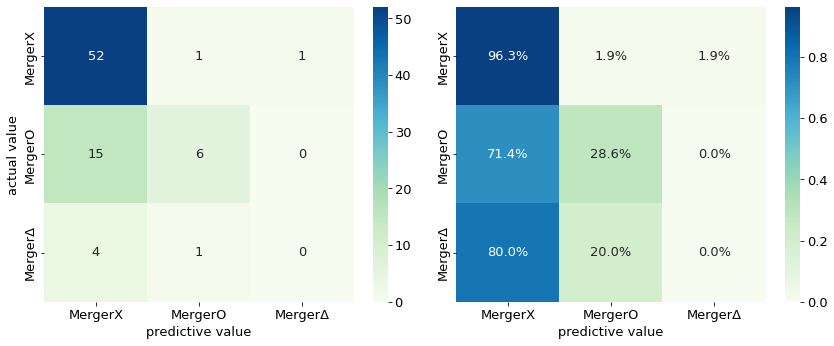

In [60]:
labels=['MergerX','MergerO','MergerΔ']
#print(data)
# Drawing confusion matrix with seaborn
plt.figure(figsize=(12,5))

ax=plt.subplot(1, 2, 1)
#sns.heatmap(cm_norm,annot=True,fmt=".1%",cmap='GnBu',xticklabels=labels, yticklabels=labels)
sns.heatmap(confM,annot=True,cmap='GnBu',xticklabels=labels, yticklabels=labels)
plt.xlabel('predictive value')
plt.ylabel('actual value')

ax=plt.subplot(1, 2, 2)
sns.heatmap(cm_norm,annot=True,fmt=".1%",cmap='GnBu',xticklabels=labels, yticklabels=labels)
#sns.heatmap(confM,annot=True,cmap='GnBu',xticklabels=labels, yticklabels=labels)
plt.xlabel('predictive value')
#plt.ylabel('actual value')


plt.tight_layout()
#plt.title(model_name)
plt.show() 

In [61]:
report=classification_report(np.argmax(y_test_hot,axis=1),np.argmax(y_pred,axis=1),output_dict=True)

df=pd.DataFrame(report).transpose()
#df.to_hdf('/tf/Results/confusion/'+str(grids)+'/Log/CNN/'+model_name+'.h5',key='Galaxy',mode='w')   
df

precision    recall  f1-score  support
0              0.732394  0.962963  0.832000   54.000
1              0.750000  0.285714  0.413793   21.000
2              0.000000  0.000000  0.000000    5.000
accuracy       0.725000  0.725000  0.725000    0.725
macro avg      0.494131  0.416226  0.415264   80.000
weighted avg   0.691241  0.725000  0.670221   80.000

# 8. Drawing Hisotries(loss,accuracy) of the models

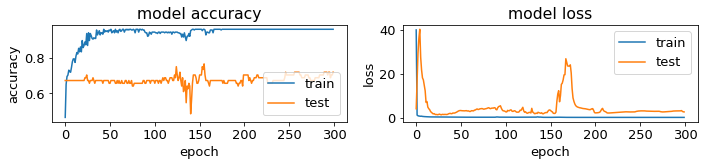

In [62]:
# plotting the metrics
fig = plt.figure(figsize=(10,2.5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()
plt.show()

# 7. Drawing Filters and Feature maps

## 7-1) summary of model

In [63]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name: continue
    # summarize output shape
    #print(i, layer.name, layer.output.shape)
    filters, biases = layer.get_weights()
    print(i,layer.name, filters.shape)

0 conv2d (9, 9, 1, 32)
4 conv2d_1 (7, 7, 32, 64)
8 conv2d_2 (5, 5, 64, 64)
12 conv2d_3 (3, 3, 64, 128)
16 conv2d_4 (3, 3, 128, 256)


## 7-2) Drawing trained filters

(9, 9, 1, 32)


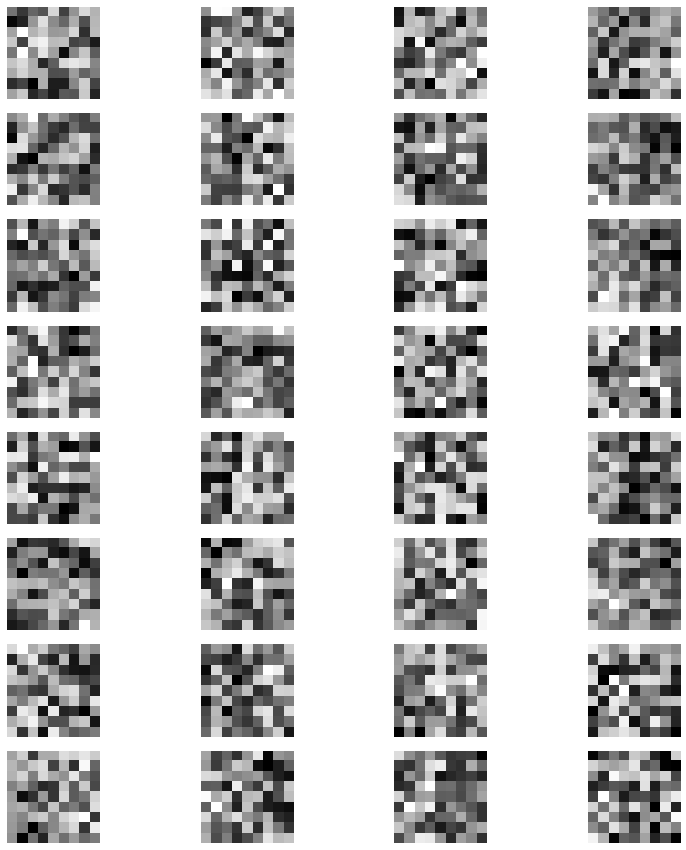

In [64]:
# 필터를 이미지로 변환하여 시각화합니다.
filters1, biases1 = model.layers[0].get_weights()
fig=plt.figure(figsize=(12, 12))
print(filters1.shape)
for i in range(filters1.shape[3]):
    ax=plt.subplot(8, 4, i + 1)
    plt.imshow(filters1[:, :, 0, i], cmap='gray')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

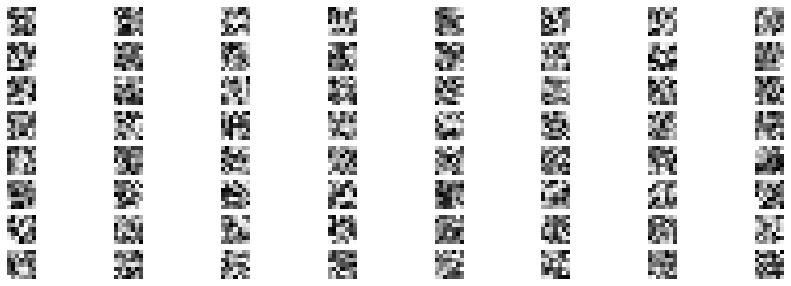

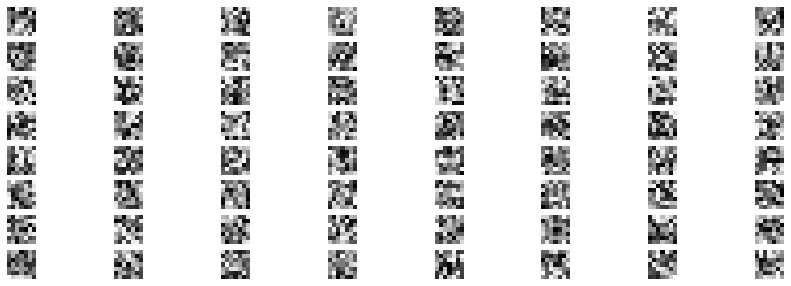

In [65]:
filters2, biases2 = model.layers[4].get_weights()
plt.figure(figsize=(15, 5))
for i in range(filters2.shape[3]):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filters2[:, :, 0, i], cmap='gray')
    plt.axis('off')
    
plt.show()
plt.figure(figsize=(15, 5))
for i in range(filters2.shape[3]):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filters2[:, :, 1, i], cmap='gray')
    plt.axis('off')
plt.show()

## 7-3) Drawing feature_maps

In [66]:
outlay=[model.layers[i].output for i in [0,4,8,12,16]]
outputs1=Model(inputs=model.inputs,outputs=outlay)

In [67]:
test=np.expand_dims(X_test[1], axis=0)
print(y_test[1])
feature_maps=outputs1.predict(test)

0


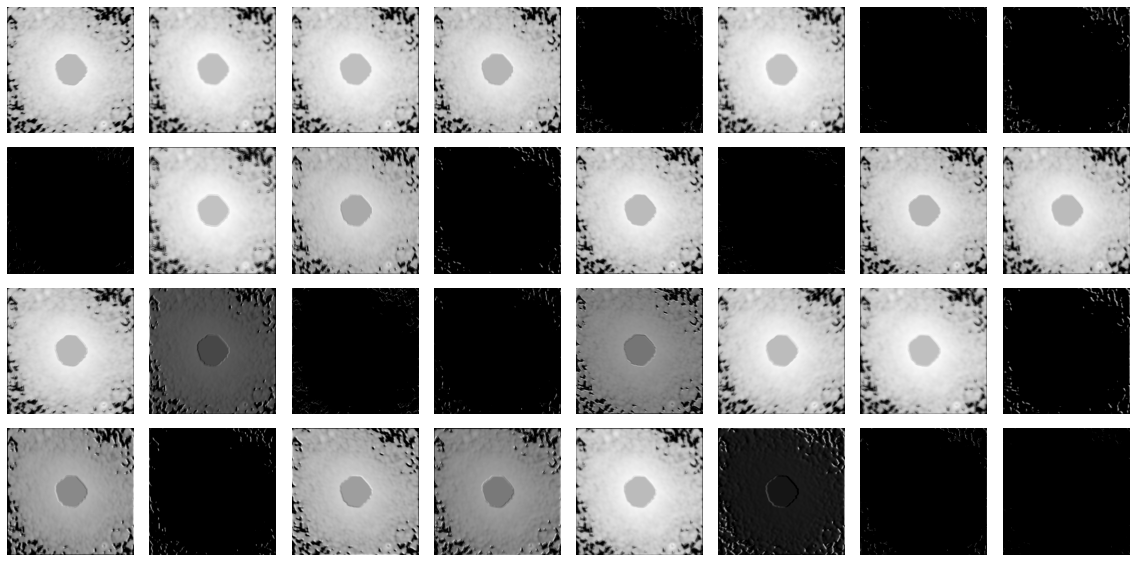

In [68]:
fig=plt.figure(figsize=(16,8))
for i in range(32):
    ax=plt.subplot(4,8,i+1)
    plt.imshow(feature_maps[0][0,:,:,i],cmap='gray')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

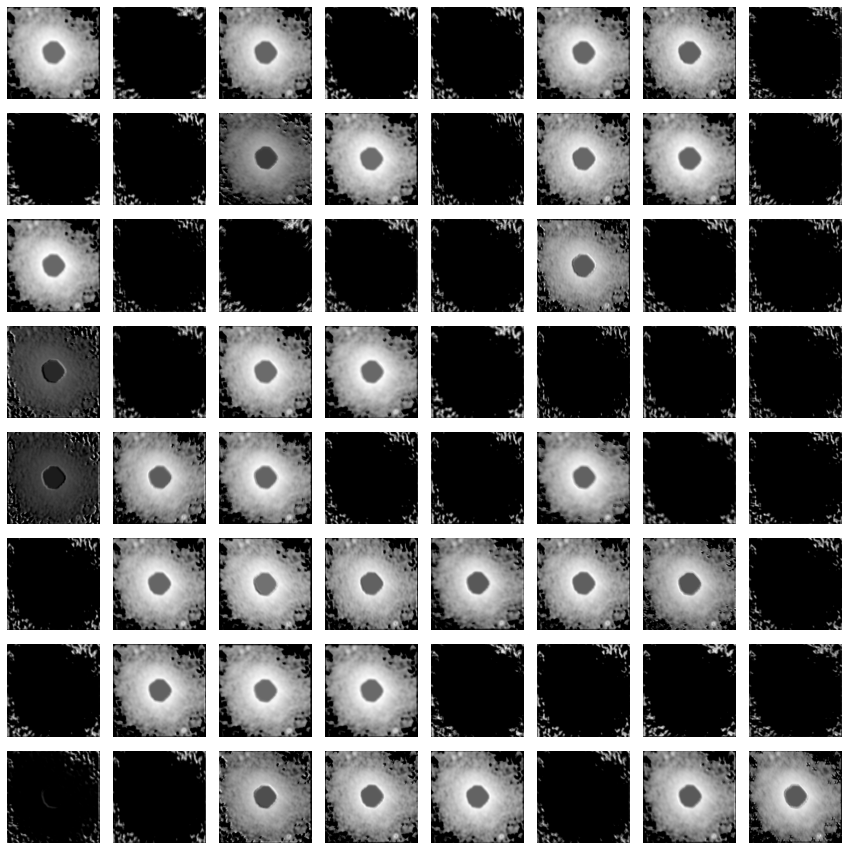

In [69]:
fig=plt.figure(figsize=(12,12))
for i in range(64):
    ax=plt.subplot(8,8,i+1)
    plt.imshow(feature_maps[1][0, :, :, i],cmap='gray')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

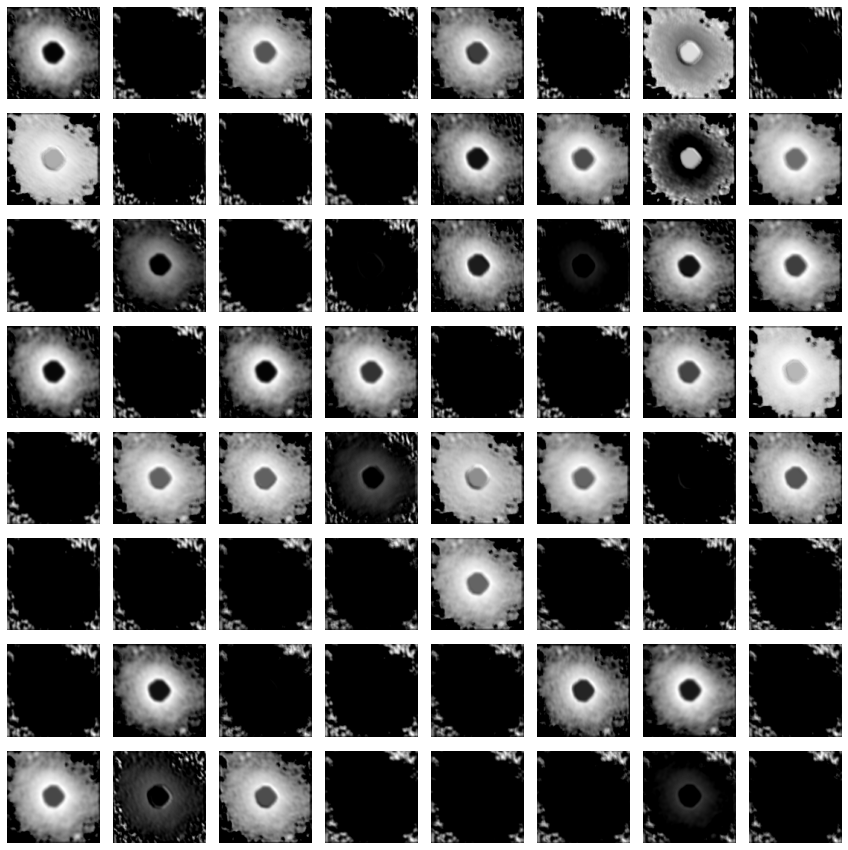

In [70]:
fig=plt.figure(figsize=(12,12))
for i in range(64):
    ax=plt.subplot(8,8,i+1)
    plt.imshow(feature_maps[2][0, :, :, i],cmap='gray')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

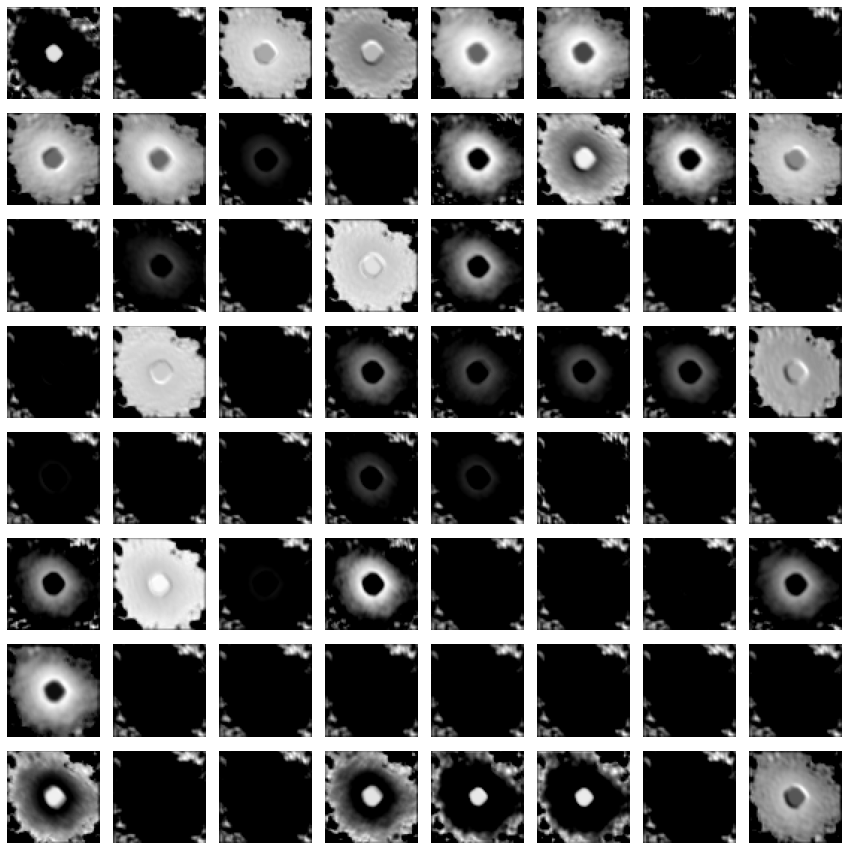

In [71]:
fig=plt.figure(figsize=(12,12))
for i in range(64):
    ax=plt.subplot(8,8,i+1)
    plt.imshow(feature_maps[3][0, :, :, i],cmap='gray')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

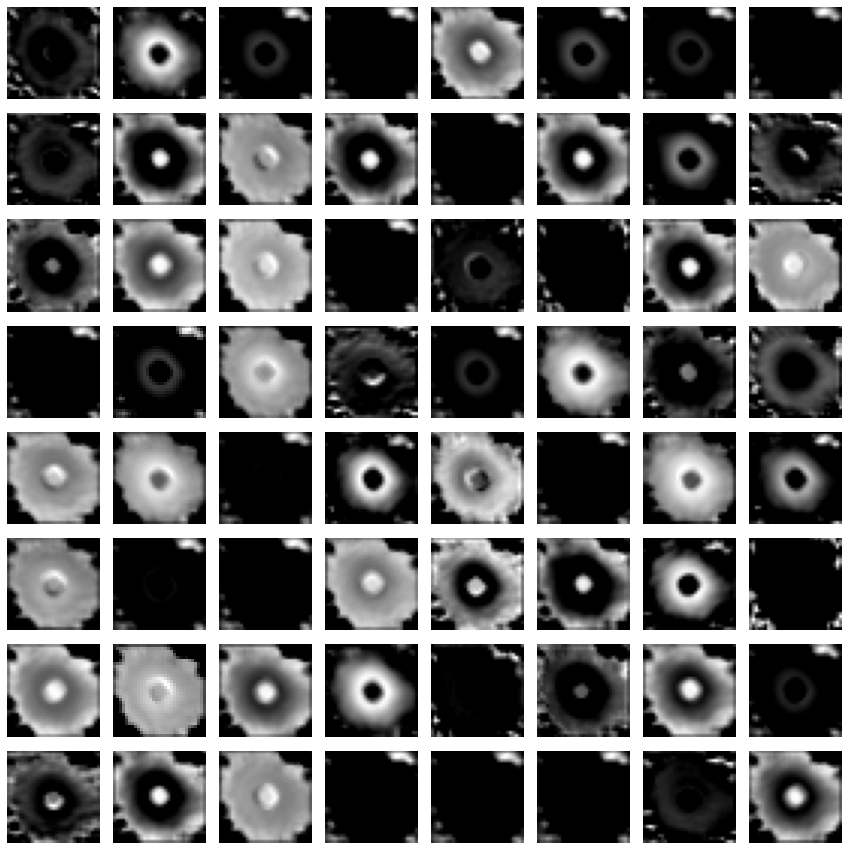

In [72]:
fig=plt.figure(figsize=(12,12))
for i in range(64):
    ax=plt.subplot(8,8,i+1)
    plt.imshow(feature_maps[4][0, :, :, i],cmap='gray')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()